# Setup

In [2]:
if (!require("xfun")) install.packages("xfun")
pkgs <- c(
  'forecast', 'vars', 'urca', 'MLmetrics', 
  'lubridate', 'tsbox', 'timetk',
  'extrafont', 'patchwork', 'hrbrthemes', 'ggthemes', 'ggsci', 'scales', 
  'tidyverse', 'vroom', 'readxl', 'writexl', 'tsibble'
)
xfun::pkg_attach2(pkgs, message = FALSE)

options(
  repr.plot.width=10, 
  repr.plot.height=6, 
  repr.plot.res = 300,
  repr.matrix.max.rows = 10,
  repr.matrix.max.cols = Inf
)

loadfonts(device = "win", quiet = TRUE)

Loading required package: xfun


Attaching package: 'xfun'


The following objects are masked from 'package:base':

    attr, isFALSE




# Load Data

In [3]:
# rice 
rice_m <- read_csv('../data/clean/rice_m.csv')
rice_m_ts <- rice_m %>% select(date, ex_white, ex_hommali) %>%
  as_tsibble(index = date) %>%  ts_ts()

# rice_price
price <- read_csv("../data/raw/rice_price.csv") %>%
  filter(year(date) < 2020)
price_ts <- price %>% as_tsibble(index = date) %>% ts_ts()

# exogenious population and gdp of world
exo <- read_csv("../data/raw/wdi_exo.csv")
exo_ts <- exo %>% as_tsibble(index = date) %>% ts_ts()

# combine
data <- ts_c(rice_m_ts, price_ts, exo_ts) %>% window(start = 2003)
data <- data %>% na.locf() # fill forward


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  year_th = col_double(),
  month = col_character(),
  ex_glutinous = col_double(),
  ex_white = col_double(),
  ex_hommali = col_double(),
  ex_pathum = col_double(),
  ex_colored = col_double(),
  date = col_date(format = "")
)


[time]: 'date' 


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  date = col_date(format = ""),
  p_w25_ind = col_double(),
  p_w25_vn = col_double(),
  p_w25_th = col_double(),
  p_h100_th = col_number(),
  p_w5_th = col_double(),
  p_w5_vn = col_double()
)


[time]: 'date' 


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  date = col_date(format = ""),
  gdppc = col_number(),
  pop = col_number()
)


[time]: 'date' 



In [4]:
# log transformation
ex_hommali <- data[, 'ex_hommali'] %>% log()
ex_white <- data[, 'ex_white'] %>% log()
p_w5_th <- data[, 'p_w5_th'] %>% log()
p_w5_vn <- data[, 'p_w5_vn'] %>% log()
p_h100_th <- data[, 'p_h100_th'] %>% log()
gdppc <- data[, 'gdppc'] %>% log()
pop <- data[, 'pop'] %>% log()

vars_list = list(
  ex_hommali = ex_hommali, 
  ex_white = ex_white, 
  p_w5_th = p_w5_th, 
  p_w5_vn = p_w5_vn, 
  p_h100_th = p_h100_th
)

# Data Visualization

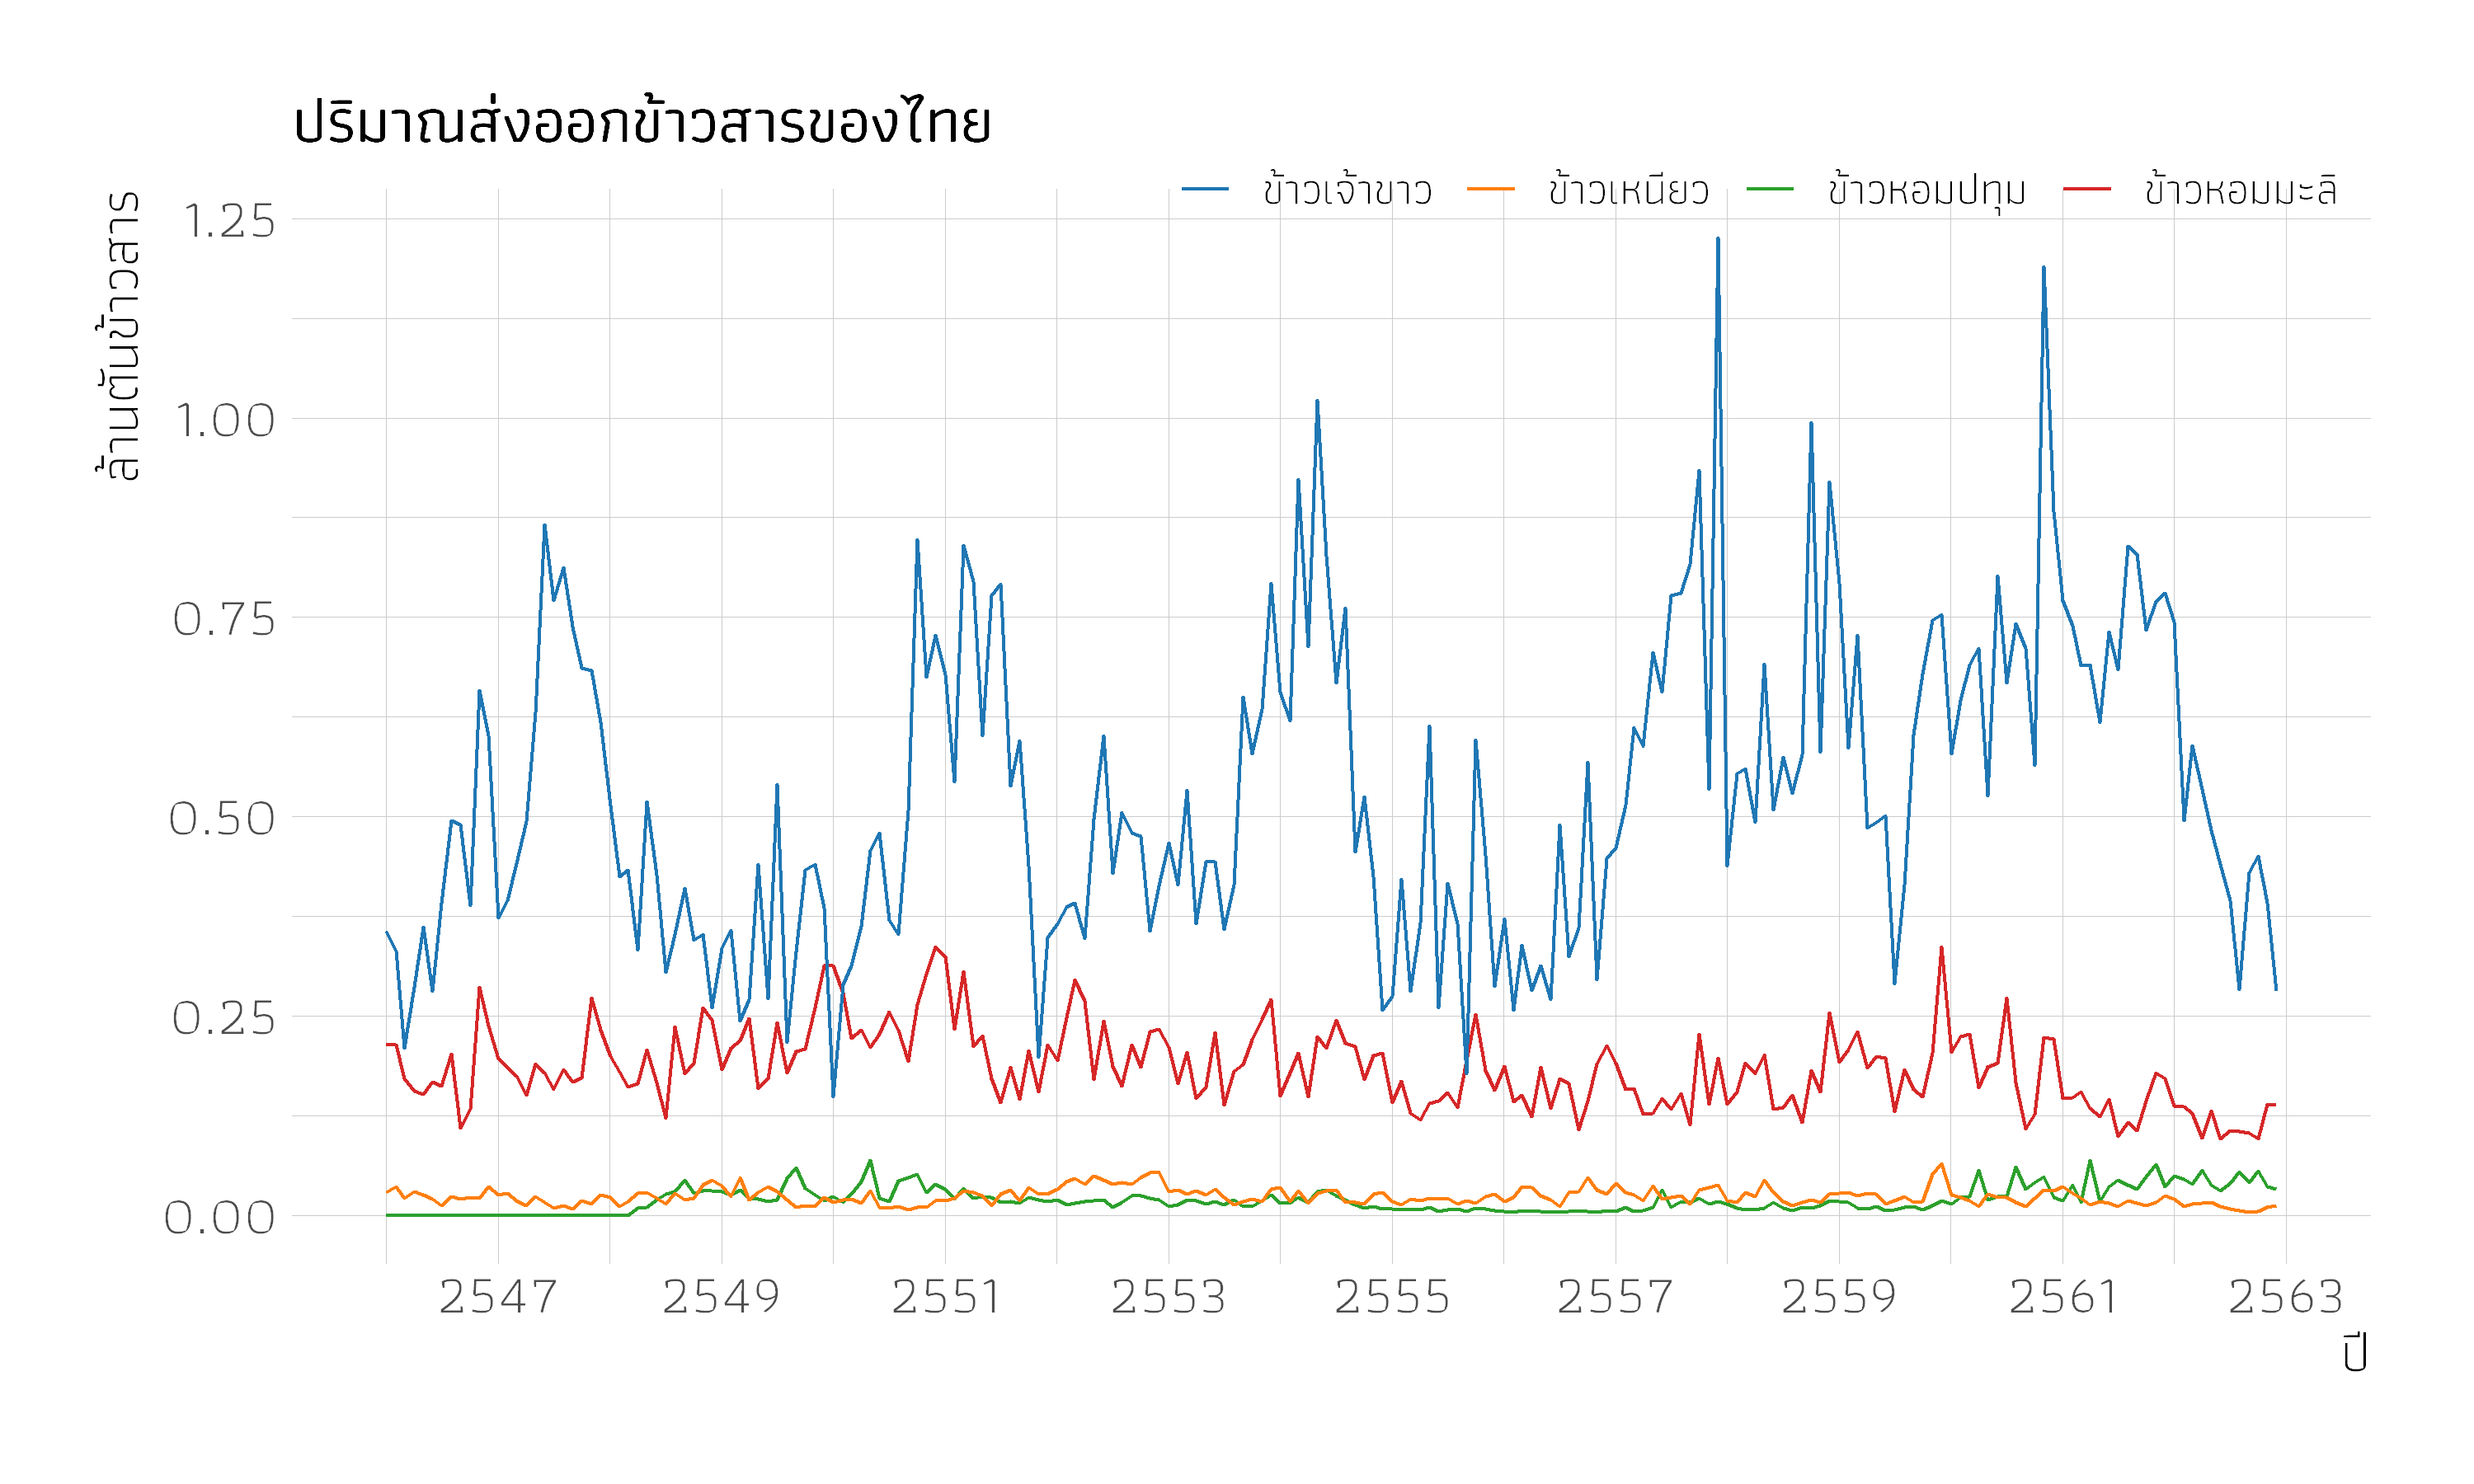

In [5]:
ggplot(rice_m %>% filter(year_th >= 2546), aes(x=date)) +
  geom_line( aes(y=ex_hommali/1e6, color = 'ข้าวหอมมะลิ')) +
  geom_line( aes(y=ex_pathum/1e6, color = 'ข้าวหอมปทุม')) +
  geom_line( aes(y=ex_white/1e6, color = 'ข้าวเจ้าขาว')) +
  geom_line( aes(y=ex_glutinous/1e6, color = 'ข้าวเหนียว')) +
  scale_color_d3() +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  labs(title = 'ปริมาณส่งออกข้าวสารของไทย',
       x =  "ปี",
       y = 'ล้านตันข้าวสาร'
      ) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  ) +
  scale_x_date(date_breaks = '2 years',
               labels = function(x) year(x)+543
               )

# ggsave('../figures/plot_export_m.png', width = 10, height = 7)

# Unit Root Test

In [6]:
get_objname <- function(x) deparse(substitute(x))

ur_adf <- function(y, n_diff = 0, varname = NULL, ...) {
  
  varname <- if (is.null(varname)) deparse(substitute(y)) else varname
  y <- if(n_diff == 0) y else diff(y, n_diff)
  
  ur.trend <- ur.df(y, type='trend', lags = 10, selectlags = "BIC", ...)
  ur.drift <- ur.df(y, type='drift', lags = 10, selectlags = "BIC", ...)
  ur.none  <- ur.df(y, type='none' , lags = 10, selectlags = "BIC", ...)

  tstat.trend <- ur.trend@teststat
  tstat.drift <- ur.drift@teststat
  tstat.none  <- ur.none@teststat

  cv.trend <- ur.trend@cval
  cv.drift <- ur.drift@cval
  cv.none  <- ur.none@cval
  
  lags.trend <- dim(ur.trend@testreg$coefficients)[1] - 3
  lags.drift <- dim(ur.drift@testreg$coefficients)[1] - 2
  lags.none  <- dim(ur.none@testreg$coefficients)[1]  - 1

  df_test = rbind(
    cbind(t(tstat.trend), cv.trend, lags.trend),
    cbind(t(tstat.drift), cv.drift, lags.drift),
    cbind(t(tstat.none) , cv.none , lags.none)
  ) %>% 
  as.data.frame() %>%
  rename(c("lag" = "lags.trend")) %>%
  rownames_to_column("hypo") %>%
  filter(str_starts(hypo, 'tau')) %>%
  mutate(
    result = ifelse(abs(statistic) >= abs(`5pct`), 'Reject', 'Accept'),
    variable = varname,
    level = paste0('d', n_diff),
    star = case_when(
      abs(statistic) > abs(`1pct`) ~ "***",
      abs(statistic) > abs(`5pct`) ~ "** ",
      abs(statistic) > abs(`10pct`) ~ "*  ",
      TRUE ~ "   "
    ),
    hypo = case_when(
      hypo == "tau3" ~ "trend",
      hypo == "tau2" ~ "constant",
      hypo == "tau1" ~ "none"
    ),
    statistic = format(round(statistic, 2), nsmall = 2) %>% 
      as.character %>% str_pad(6, "left")
  ) %>%
  select(variable, hypo, level, everything())
  
  return(df_test)
}

adf_table <- function(ur_adf) {
  ur_adf %>% 
    mutate(
      stat_star = glue::glue(
        "{statistic}{star}({lag})"
      ) %>% as.character()
    ) %>%
    pivot_wider(
      id_cols = c("variable"),
      names_from = c("level", "hypo"),
      values_from = c("stat_star")
    )
}

In [7]:
varnames = rep(names(vars_list), 1)

params = expand_grid(varnames, c(0,1)) %>%
  set_names(c('names', 'ndiff')) %>%
  mutate(ser = vars_list[names])

In [142]:
pmap(list(params$ser, params$ndiff, params$names), 
     function(first, second, third) {
       ur_adf(first, second, third)
     }) %>% 
  reduce(rbind) %>% adf_table() %>%
  write_xlsx('../results/adf_table.xlsx')

In [29]:
ex_hommali %>% subset(end = 12*14)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2003,12.27506,12.26935,12.05043,11.95592,11.93138,12.02668,11.99204,12.21806,11.59842,11.79892,12.56541,12.37573
2004,12.18385,12.13132,12.06941,11.92308,12.15140,12.09397,11.97000,12.11370,12.02850,12.05778,12.51565,12.35654
2005,12.20028,12.10040,11.98678,12.01373,12.24296,12.02176,11.70544,12.37199,12.08751,12.15995,12.46957,12.40910
2006,12.11371,12.25000,12.29707,12.41546,11.97300,12.05084,12.39497,12.09268,12.23232,12.24751,12.46998,12.65313
2007,12.65482,12.53970,12.30977,12.35325,12.25791,12.33392,12.45028,12.35567,12.17114,12.48272,12.61910,12.72745
2008,12.69003,12.36107,12.63030,12.25981,12.32296,12.04893,11.86086,12.12944,11.88442,12.23491,11.94604,12.27164
2009,12.17636,12.42172,12.59405,12.49948,12.04548,12.40440,12.13824,11.99642,12.27100,12.12971,12.34684,12.36161
2010,12.25799,12.01384,12.22843,11.89214,11.98828,12.34012,11.83289,12.10238,12.14565,12.30094,12.40996,12.50969
2011,11.91711,12.09319,12.22329,11.90842,12.32057,12.25237,12.40825,12.28132,12.26438,12.04506,12.20598,12.21964
2012,11.85914,12.02908,11.76116,11.69006,11.84962,11.87401,11.94425,11.81484,12.17445,12.43721,12.10684,11.96141


In [102]:
ets_vec = Vectorize(ets)
x = ex_hommali %>% subset(end = 120)
params = list(y = x, model = "ZZZ", damped = FALSE)

# ets(ex_hommali %>% subset(end = 120), params)
res = do.call(ets, params)

In [107]:
# forecast(res, 12)
# ets(ex_hommali %>% subset(end = 120), model = "ZZZ", damped = FALSE) %>% str()

In [12]:
params = list(model = "ZZZ", damped = FALSE)
c(y = "xx", params)

[1] "list"

# Strategy
1. 

In [1]:
do.call(forecast::ets, params)

ERROR: Error in do.call(forecast::ets, params): object 'params' not found


## ETS

In [165]:
params = list(model = "ZZZ", damped = NULL)

ets_fcast = function(i, data, params, h=1) {
  y = data %>% subset(end = i)
  params$y = y
  fitted = do.call(forecast::ets, params)
  res = fitted %>% forecast(h=h) %>% as.data.frame()
  return(res)
}

rolling_ets = function(data, params, n_initial, h) {
  n_sample = length(data)
  res = n_initial:n_sample %>% 
    map(ets_fcast, data = data, params = params, h = h) %>% 
    reduce(rbind)
  return(res)
}

x = rolling_ets(
  ex_hommali, 
  params = list(model = "AAA", damped = TRUE) , 
  n_initial = 168, h = 2)

x %>% exp()

,Point Forecast,Lo 80,Hi 80,Lo 95,Hi 95
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jan 2017,204415.6,159000.9,262801.9,139199.5,300185.9
Feb 2017,202253.3,155814.4,262532.8,135717.8,301407.9
Feb 20171,198759.6,154874.4,255080.1,135713.7,291093.7
Mar 2017,202552.7,156946.3,261411.8,137121.0,299207.4
Mar 20171,212093.3,165290.4,272148.6,144853.1,310545.9
...,...,...,...,...,...
Dec 2019,145182.9,112442.08,187457.1,98214.62,214612.3
Dec 20191,149030.7,116418.12,190779.1,102151.13,217424.3
Jan 2020,120397.4,93093.85,155708.9,81244.24,178419.3


## ARIMA

## VARS/VECM

In [146]:
endo <- data[, c("ex_white", "ex_hommali", 
                 "p_w5_th", "p_w5_vn", "p_h100_th")]
exo <- data[, c("gdppc", "pop")]

In [156]:
x <- ca.jo(endo, type = "trace", ecdet = "const", season = 12)

In [59]:
# fit function
fets = function(x, model='AAN', damped = FALSE, h=h) {
  forecast::ets(x, model = model, damped = damped) %>% forecast(h=h)
}

fets.auto = function(x, h=h) {
  forecast::ets(x, model = 'ZZZ', damped = NULL) %>% forecast(h=h)
}

farima = function(x, order = c(0,0,0), seasonal = c(0,0,0), h=h) {
  forecast::Arima(x,
                  order = order, 
                  seasonal = seasonal,
                 ) %>% forecast(h=h)
}

farima.auto = function(x, d=0, h=h) {
  forecast::auto.arima(x, d=d) %>% forecast(h=h)
}


# accuracy measurement
rmse = function(data, h = h) {
  data = data %>% select('actual', starts_with('yhat')) %>% exp()
  h = ncol(data) - 1
  for (i in seq(h)) {
    data[, paste0('e', i)] = (
      lead(data[,'actual'], i) - data[, paste0('yhat', i)]
    )^2
  }
  rmse_score = data %>% select(starts_with('e')) %>% 
    as.matrix() %>% mean(na.rm = TRUE) %>% sqrt()
  
  return(rmse_score)
}

mape = function(data, h = h) {
  data = data %>% select('actual', starts_with('yhat')) %>% exp()
  h = ncol(data) - 1
  for (i in seq(h)) {
    data[, paste0('e', i)] = abs(
      lead(data[,'actual'], i) - data[, paste0('yhat', i)]
    )*100 / lead(data[,'actual'], i)
  }
  mape_score = data %>% select(starts_with('e')) %>% 
    as.matrix() %>% mean(na.rm = TRUE)
  
  return(mape_score)
}

eval_ets = function(x, params, h = 2, initial = 11) {
  pmap(
    list(params$model, params$damped), 
    function(first, second) {
      
      # 1 compute forecast error using time series cross validation
      error = tsCV(x, fets, h = h, initial = initial, 
                   model = first, 
                   damped = second
                  ) %>% as.data.frame()
      new_colnames = c('actual', paste0('e', seq(1:h)))
      error = data.frame(x, error) %>% set_names(new_colnames)
      
      # 2 compute predicted (yhat)
      for (i in seq(h)) {
        error[, paste0('yhat', i)] = (
          lead(error[,'actual'], i) - error[, paste0('e', i)]
        )
      }
      
      # 3 compute rmse, mape
      data.frame(
        model = paste(first, second, sep = '-'),
        rmse = rmse(error),
        mape = mape(error)
      ) %>% na.omit()
    }
  ) %>% 
  reduce(bind_rows) %>%
  arrange(rmse)
}

eval_arima = function(x, params, h = 2, initial = 11) {
  pmap(
    list(params$order, params$seasonal), 
    function(first, second) {
      
      # 1 compute forecast error using time series cross validation
      error = tsCV(x, farima, h = h, initial = initial, 
                   order = first, 
                   seasonal = second
                  ) %>% as.data.frame()
      new_colnames = c('actual', paste0('e', seq(1:h)))
      error = data.frame(x, error) %>% set_names(new_colnames)
      
      # 2 compute predicted (yhat)
      for (i in seq(h)) {
        error[, paste0('yhat', i)] = (
          lead(error[,'actual'], i) - error[, paste0('e', i)]
        )
      }
  
      # 3 compute rmse, mape
      data.frame(
        model = paste(paste(first, collapse = ','), 
                      paste(second, collapse = ','), sep = '-'),
        rmse = rmse(error),
        mape = mape(error)
      ) %>% na.omit()
    }
  ) %>% 
  reduce(bind_rows) %>%
  arrange(rmse)
}

## Export

In [7]:
# ETS params
Z1 = c('A','M')
Z2 = c('N', 'A', 'M')
Z3 = c('N', 'A', 'M')
damped = c(FALSE, TRUE)

ets_params = expand.grid(Z1, Z2, Z3, damped) %>%
  mutate(
    model = paste0(Var1, Var2, Var3),
    damped = Var4
) %>% select(model, damped)

# ARIMA params
p = seq(0,2)
q = seq(0,2)
P = seq(0,1)
Q = seq(0,1)

arima_params = expand.grid(p,q,P,Q) %>% rowwise() %>%
  mutate(
    order = pmap(list(Var1, Var2), function(x, y) c(x, 0, y)),
    seasonal = pmap(list(Var3, Var4), function(x, y) c(x, 0, y)),
  ) %>% select(order, seasonal)

In [61]:
h = 1
initial = 180

e.ets.ex_hml = eval_ets(
  ex_hommali %>% log(), params = ets_params, h = h, initial = initial
)
e.ets.ex_wht = eval_ets(
  ex_white %>% log(), params = ets_params, h = h, initial = initial
)

In [60]:
e.arima.ex_hml = eval_arima(
  ex_hommali %>% log(), params = arima_params, h = h, initial = initial
)
e.arima.ex_wht = eval_arima(
  ex_white %>% log(), params = arima_params, h = h, initial = initial
)

In [166]:
# acc_ex_hml1 = list(ets = e.ets.ex_hml, e.arima.ex_hml)
# acc_ex_pat1 = list(ets = e.ets.ex_pat, e.arima.ex_pat)
# acc_ex_wht1 = list(ets = e.ets.ex_wht, e.arima.ex_wht)
# acc_ex_glu1 = list(ets = e.ets.ex_glu, e.arima.ex_glu)

In [116]:
acc_ex_hml = list(ets = e.ets.ex_hml %>% head(3), 
                  arima = e.arima.ex_hml %>% head(3))
acc_ex_wht = list(ets = e.ets.ex_wht %>% head(3), 
                  arima = e.arima.ex_wht %>% head(3))

In [117]:
acc_ex_hml

,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,MAA-TRUE,30580.81,14.55500
2,AAA-TRUE,30658.27,14.84307
3,MAA-FALSE,31408.06,14.44599
,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,"1,0,1-1,0,1",32791.97,14.79931
2,"1,0,2-1,0,1",32945.13,14.79039
3,"2,0,2-1,0,1",33266.16,15.24737


In [118]:
acc_ex_wht

,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,MMN-FALSE,132753.9,15.30863
2,MAN-TRUE,132927.5,15.46713
3,MNN-FALSE,133159.1,15.52590
,model,rmse,mape
,<chr>,<dbl>,<dbl>
1,"1,0,1-1,0,1",133799.2,14.71509
2,"2,0,1-1,0,1",133894.7,14.66646
3,"1,0,2-1,0,1",135090.4,14.62805


In [65]:
fets <- function(x, model='AAN', damped = FALSE, h=1) {
  forecast(ets(x, model=model, damped = damped), h=h)
}

farima <- function(x, d, h=1) {
  forecast(auto.arima(x, d=d), h=h)
}

In [104]:
accuracy(res_hml)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.01264841,0.2426748,0.1746821,-0.1362174,1.467919,0.6986989,0.009953759


In [113]:
accuracy_ = function(actual, fitted) {
  error = actual - fitted
  n = length(actual)
  rmse = sqrt(sum(error**2)/n)
  mape = mean(abs(error/actual)*100)
  res = data.frame(rmse, mape)
  return(res)
}

In [119]:
actual = ex_hommali %>% window(end = c(2016, 12))
fitted_model = ets(actual %>% log(), model = 'MAA', damped = TRUE)
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
46771.2,20.48349


In [123]:
actual = ex_hommali %>% window(end = c(2016, 12))
fitted_model = Arima(actual %>% log(), 
                     order = c(1,0,1), seasonal = c(1,0,1)
                    )
 
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
43084.16,19.49877


In [121]:
actual = ex_white %>% window(end = c(2016, 12))
fitted_model = ets(actual %>% log(), model = 'MMN', damped = FALSE)
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
147588.5,24.40439


In [124]:
actual = ex_white %>% window(end = c(2016, 12))
fitted_model = Arima(actual %>% log(), 
                     order = c(1,0,1), seasonal = c(1,0,1)
                    )
fitted = exp(fitted_model$fitted)
accuracy_(actual, fitted)

rmse,mape
<dbl>,<dbl>
140631.1,23.01223


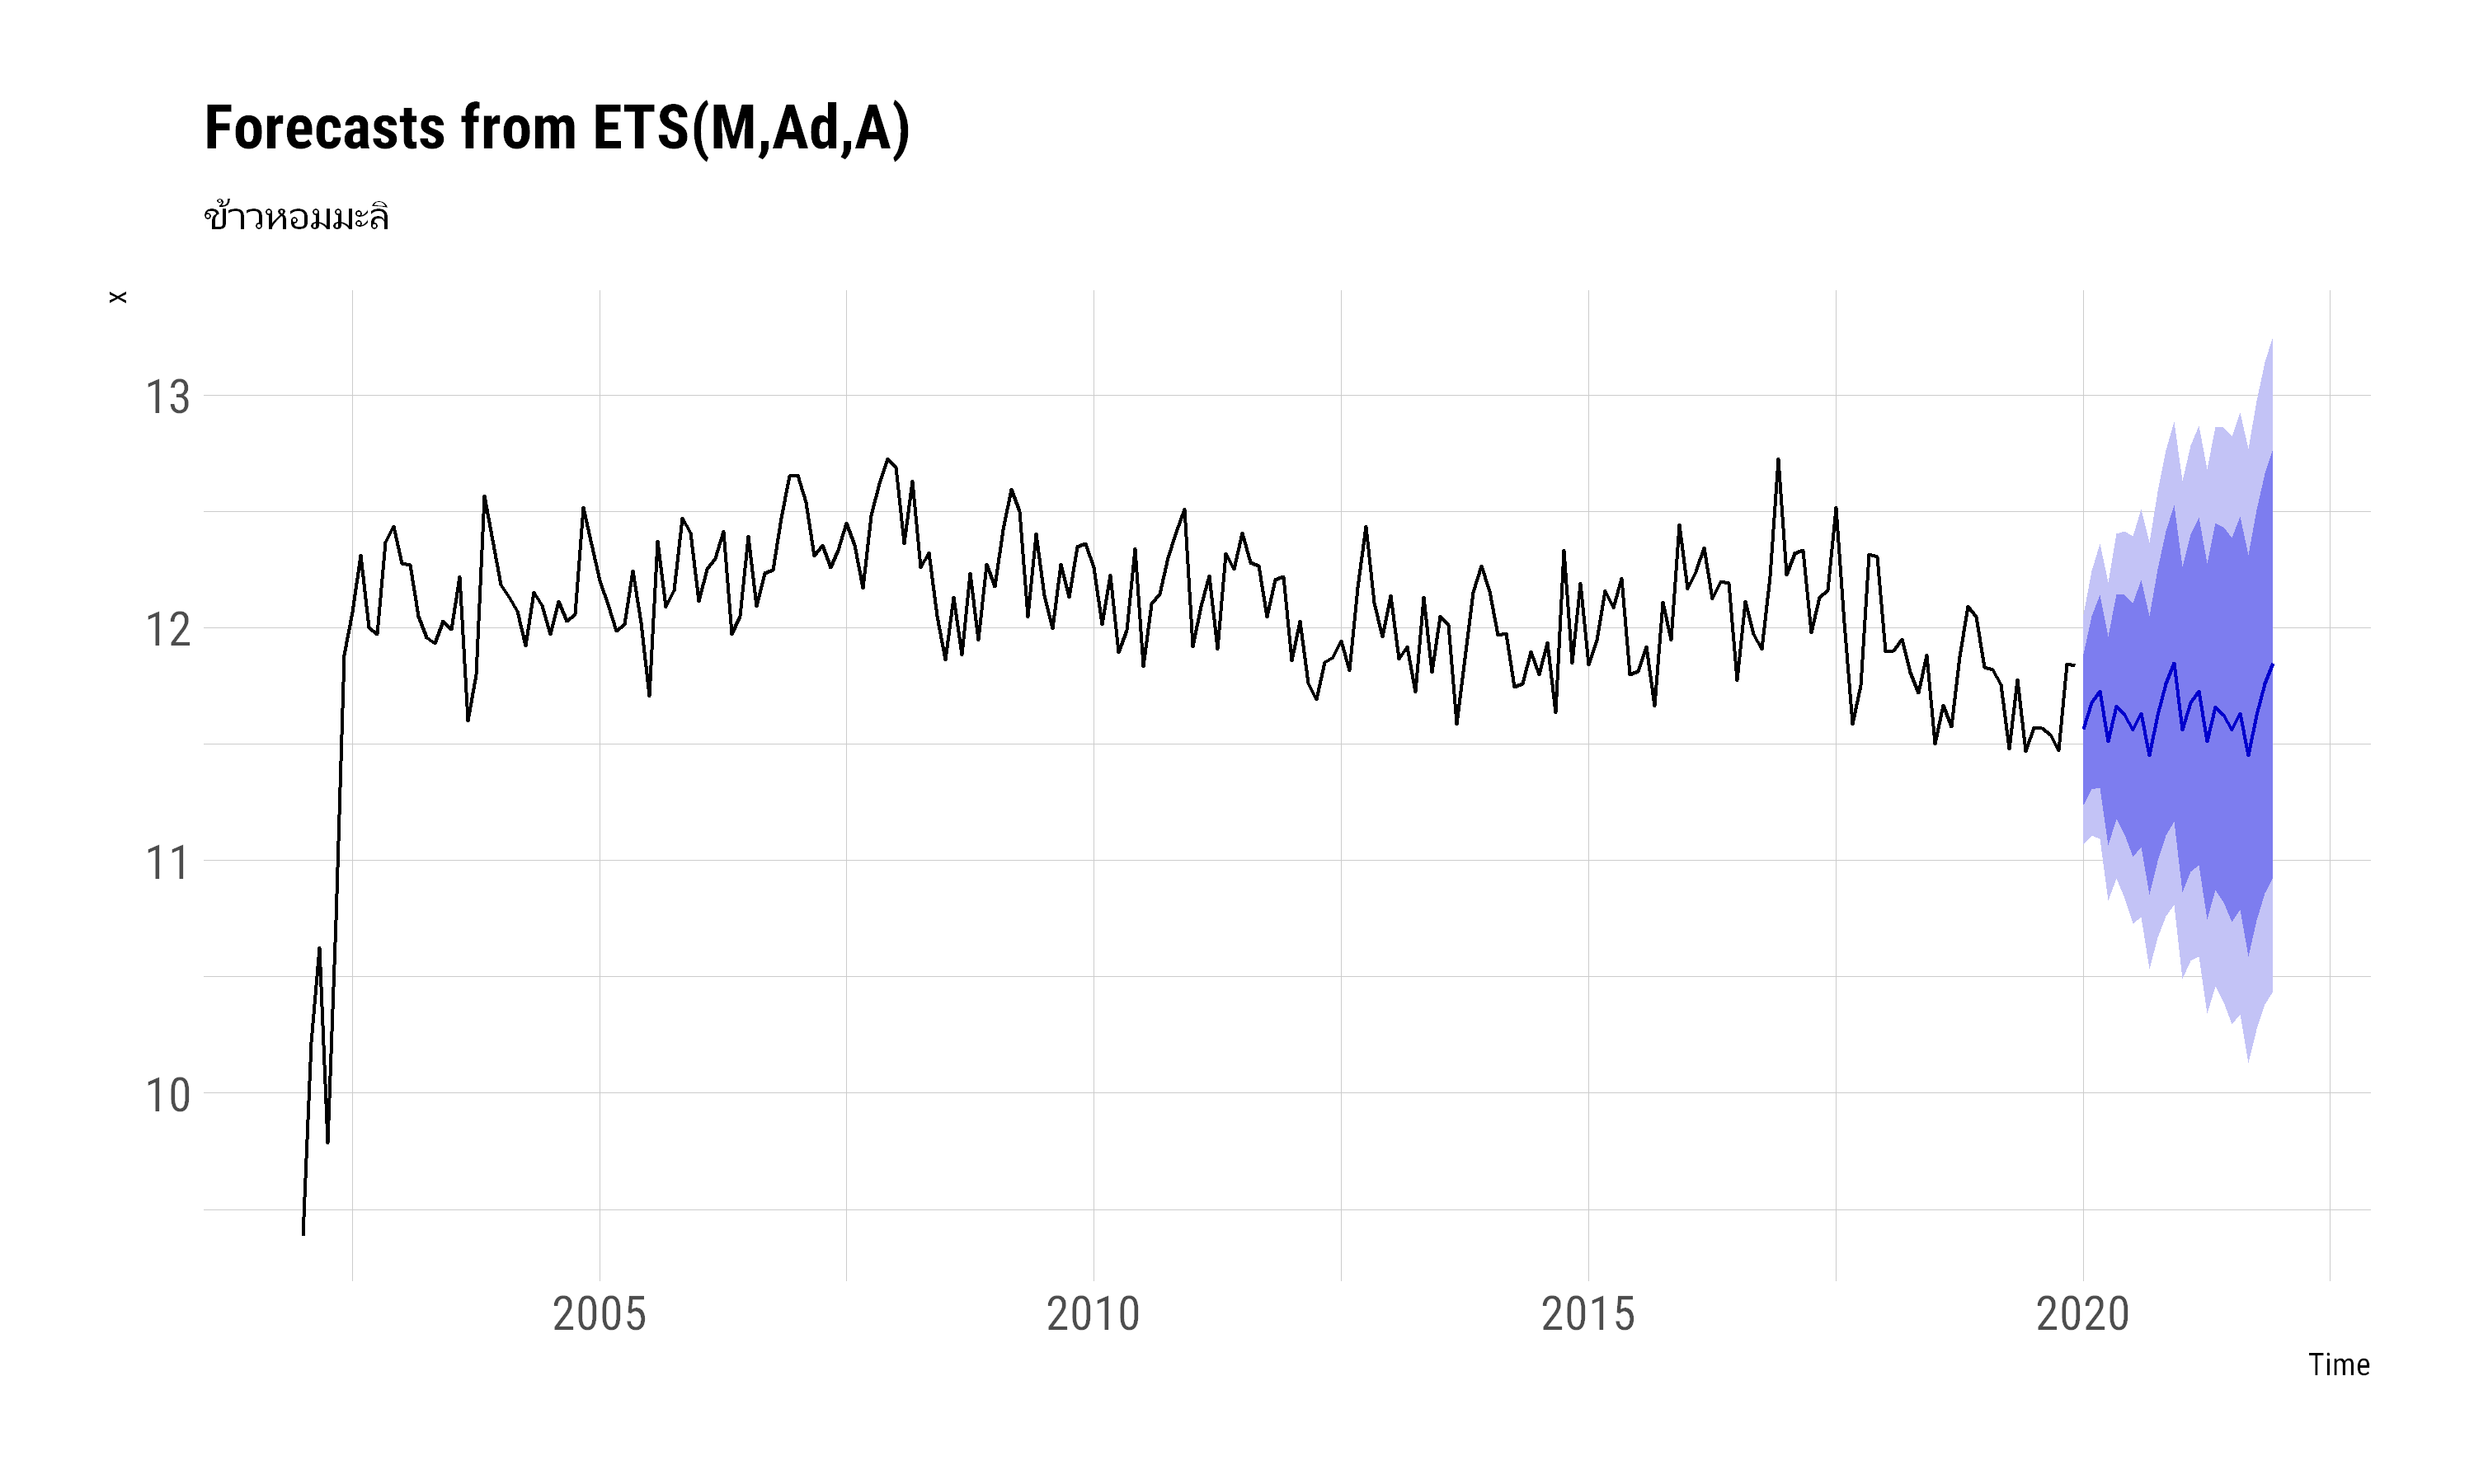

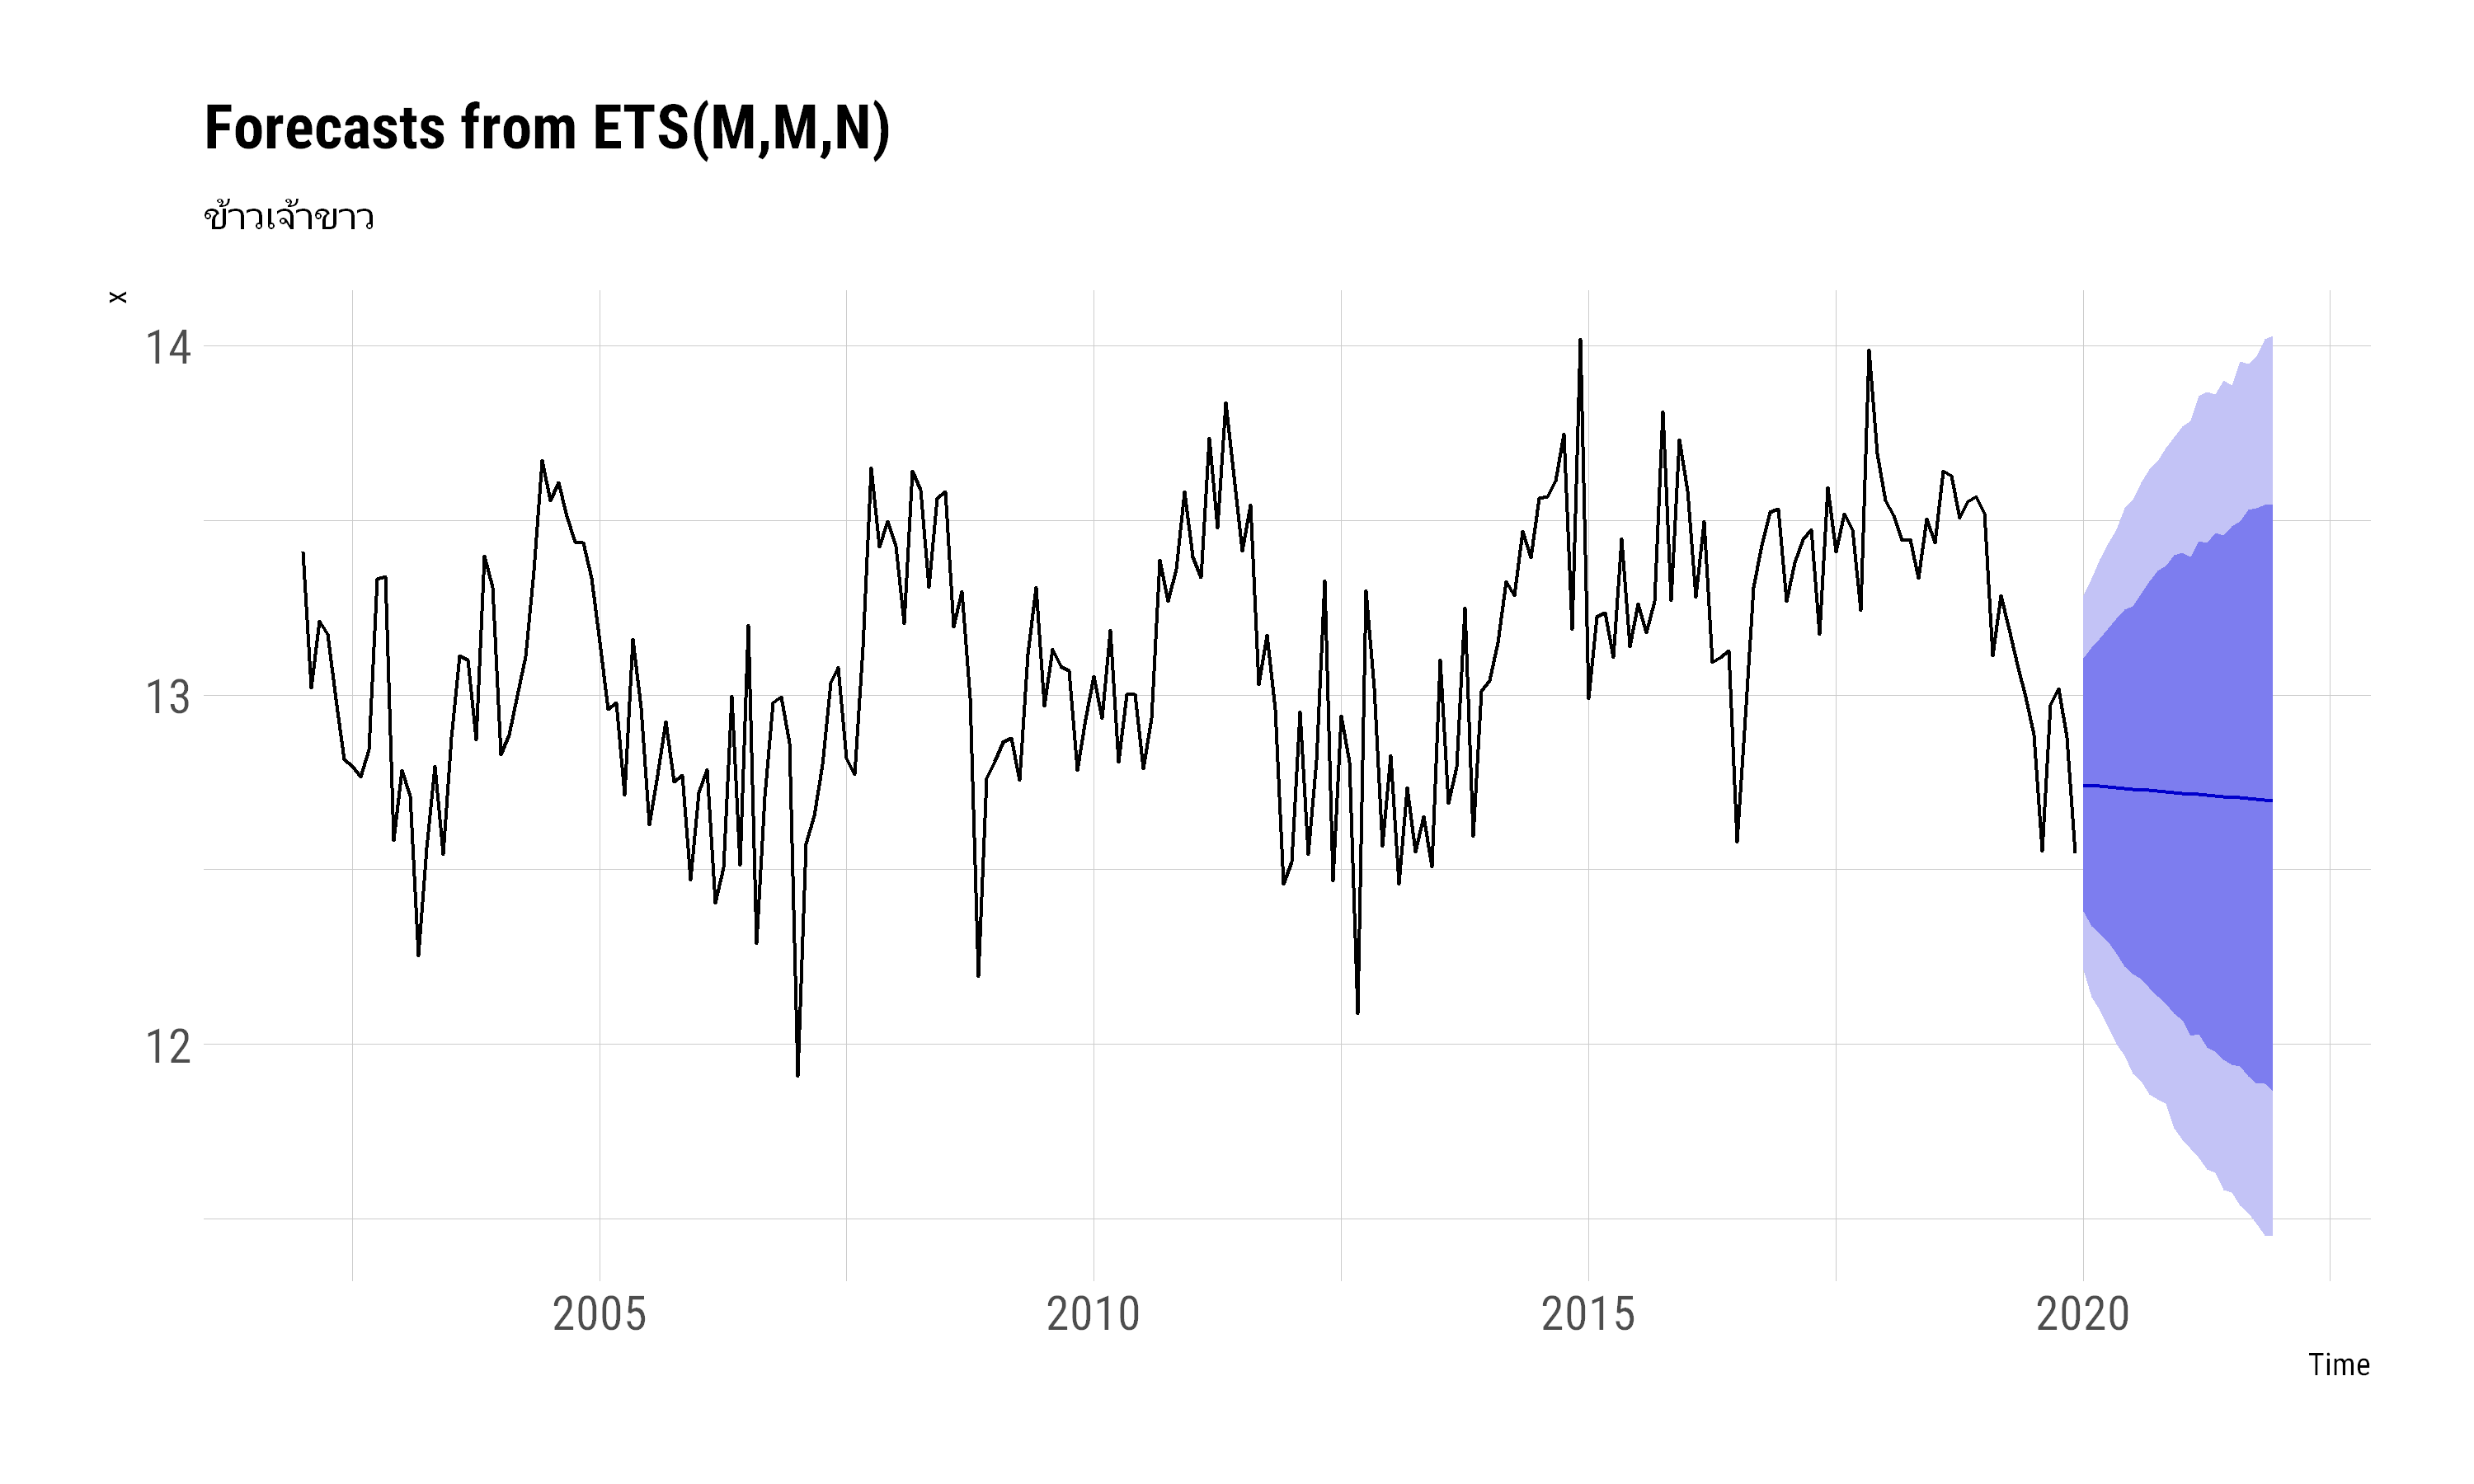

In [67]:
fets(ex_hommali %>% log(), model = 'MAA', damped = TRUE, h = 24) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวหอมมะลิ')
ggsave('../figures/plot_ets_hommali_ex.png', width = 10, height = 5)


fets(ex_white %>% log(), model = 'MMN', damped = FALSE, h = 24) %>% 
  autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'ข้าวเจ้าขาว')
ggsave('../figures/plot_ets_white_ex.png', width = 10, height = 5)

In [68]:
fets(ex_hommali %>% log(), model = 'MAA', damped = TRUE, h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_hml.csv')

fets(ex_white %>% log(), model = 'MMN', damped = FALSE, h = 24) %>%
  as.data.frame() %>%
  write_excel_csv('../results/export_wht.csv')

# farima(ex_pathum %>% log(), 
#        order = c(1,0,1), seasonal = c(1,0,1), h = 24) %>%
#   as.data.frame() %>%
#   write_excel_csv('../results/export_pat.csv')


# farima(ex_glutinous %>% log(), 
#        order = c(2,0,1), 
#        seasonal = c(1,0,1), h = 24) %>%
#   as.data.frame() %>%
#   write_excel_csv('../results/export_glu.csv')

In [ ]:
fets(log(ts_export[,'ex_hommali']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_ets_exp_hml.png', width = 8, height = 5)

fets(log(ts_export[,'ex_pathum']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_ets_exp_pat.png', width = 8, height = 5)

fets(log(ts_export[,'ex_white']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_ets_exp_wht.png', width = 8, height = 5)

fets(log(ts_export[,'ex_glutinous']), h = 24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_ets_exp_glu.png', width = 8, height = 5)

## ARIMA

In [ ]:
farima <- function(x, d, h=2) {
  forecast(auto.arima(x, d=d), h=h)
}

In [ ]:
farima(log(data$dom_hommali), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_arima_dom_hml.png', width = 8, height = 4)

farima(log(data$dom_pathum), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_arima_dom_pat.png', width = 8, height = 4)

farima(log(data$dom_white), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_arima_dom_wht.png', width = 8, height = 4)

farima(log(data$dom_glutinous), d=1, h=2) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_arima_dom_glu.png', width = 8, height = 4)

In [ ]:
farima(log(ts_export[, 'ex_hommali']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Hommali Rice')
ggsave('../figures/plot_arima_exp_hml.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_pathum']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Pathumtani Rice')
ggsave('../figures/plot_arima_exp_pat.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_white']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'White Rice')
ggsave('../figures/plot_arima_exp_wht.png', width = 8, height = 4)

farima(log(ts_export[, 'ex_glutinous']), d=1, h=24) %>% autoplot() +
  theme_ipsum_rc(base_size = 14) + 
  labs(subtitle = 'Glutinous Rice')
ggsave('../figures/plot_arima_exp_glu.png', width = 8, height = 4)

In [ ]:
# Compute CV errors for ETS as e1
e1 <- tsCV(log(data$dom_hommali), fets, h=2, initial = 10)
# Compute CV errors for ARIMA as e2
e2 <- tsCV(log(data$dom_hommali), farima, d=1, h=2, initial = 10)

# MSE
# sqrt(mean(e1[10:13,]^2))
# sqrt(mean(e2[10:13,]^2))

# # MAE
# mean(abs(e1[10:13,]))
# mean(abs(e2[10:13,]))

In [ ]:
forecast(ets(log(data$ex_hommali)), h = 2)

In [ ]:
forecast(auto.arima(log(data$dom_glutinous), d = 1), h = 2) %>% autoplot()

## VAR

In [89]:
gdppc2 = gdppc ** 2

In [177]:
endo = ts_c(ex_hommali, ex_white, p_h100_th, p_w5_th, p_w5_vn)
exo = ts_c(gdppc, gdppc2, pop)
class(exo)

[1] "mts"    "ts"     "matrix"

In [198]:
# endo[, "ex_hommali"] %>% stats::lag()

In [178]:
VARselect(endo, exogen = exo)

,1,2,3,4,5,6,7,8,9,10
AIC(n),-2.411883e+01,-2.460445e+01,-2.460522e+01,-2.449660e+01,-2.441293e+01,-2.434561e+01,-2.438279e+01,-2.437034e+01,-2.437668e+01,-2.429026e+01
HQ(n),-2.382482e+01,-2.414711e+01,-2.398454e+01,-2.371258e+01,-2.346557e+01,-2.323491e+01,-2.310876e+01,-2.293296e+01,-2.277597e+01,-2.252621e+01
SC(n),-2.339187e+01,-2.347362e+01,-2.307052e+01,-2.255803e+01,-2.207049e+01,-2.159931e+01,-2.123262e+01,-2.081630e+01,-2.041877e+01,-1.992848e+01
FPE(n),3.353102e-11,2.064799e-11,2.066467e-11,2.309773e-11,2.521668e-11,2.713019e-11,2.634679e-11,2.695272e-11,2.713396e-11,3.006649e-11


In [107]:
ca.jo(endo, ecdet = 'const', K = 2) %>% summary()


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  2.539564e-01  2.408708e-01  1.172973e-01  4.312912e-02  3.226258e-02
[6] -2.775932e-17

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 4 |  7.02  7.52  9.24 12.97
r <= 3 |  9.43 13.75 15.67 20.20
r <= 2 | 26.70 19.77 22.00 26.81
r <= 1 | 58.97 25.56 28.14 33.24
r = 0  | 62.70 31.66 34.40 39.79

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              ex_hommali.l2 ex_white.l2 p_h100_th.l2  p_w5_th.l2 p_w5_vn.l2
ex_hommali.l2      1.000000   1.0000000     1.000000   1.0000000  1.0000000
ex_white.l2       -2.673236   0.8153670    -5.200744   0.4034286 -0.3821251
p_h100_th.l2       1.010193   0.3468922     6.229011   5.2071079 -3.8531702
p_w5_th.l2        -9.325672   1.9521473     9.012842 -14.970704

In [203]:
# subset(endo, end = 180)

In [199]:
var_fitted = VAR(
  endo, 
  p = 2, 
  type = "const", 
  exogen = exo)

In [109]:
serial.test(vecm_export, lags.pt=12, type="PT.asymptotic")


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_export
Chi-squared = 313.84, df = 250, p-value = 0.003771

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_export
Chi-squared = 313.84, df = 250, p-value = 0.003771



In [176]:
vecm_export[['varresult']][['ex_hommali']]


Call:
lm(formula = y ~ -1 + ., data = datamat)

Coefficients:
ex_hommali.l1    ex_white.l1   p_h100_th.l1     p_w5_th.l1     p_w5_vn.l1  
       0.4350        -0.1344        -1.0062         0.1538         0.9983  
ex_hommali.l2    ex_white.l2   p_h100_th.l2     p_w5_th.l2     p_w5_vn.l2  
       0.1274         0.1087         0.9347        -0.2242        -0.9118  
        const          gdppc         gdppc2            pop  
     -89.3222        22.3329        -1.2350        -0.2452  


In [144]:
forecast(vecm_export, h = 1, exogen = exo[216]) %>% autoplot()
# ggsave('../figures/plot_vecm_exp.png', width = 14, height = 8)

ERROR: Error in predict.varest(object, n.ahead = h, ci = level[i]/100, ...): 
No matrix for dumvar supplied, but object varest contains exogenous variables.

